In [14]:
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
from pandas import datetime
from pandas import read_csv
from scipy.stats.stats import pearsonr   
from matplotlib import pyplot
from numpy import unravel_index
import math

### Read precipitation data (monthly mean) from NetCDF4

In [15]:
def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
       return datetime.strptime(x, '%Y0%m') 
df = read_csv('../preprocessed/indice_olr_excluded.csv', header=0, parse_dates=[0], 
              index_col=0, date_parser=parser)

nc = Dataset("/Users/yjiang/Desktop/DLocean/data/precip.mon.mean.nc", "r", format="NETCDF4")
precip_full = np.array(nc.variables['precip'][:])

### Calculate the precip anomaly

In [16]:
a = np.zeros(shape = (math.ceil(precip_full.shape[0]/12)*12, precip_full.shape[1], precip_full.shape[2]))
a[0:precip_full.shape[0]] = precip_full
a = a.reshape(int(a.shape[0]/12), 12, a.shape[1], a.shape[2])
monthly_sum = np.sum(a, axis=0)

montly_mean_1_10 = monthly_sum[0:10,:,:]/a.shape[0]
montly_mean_11_12 = monthly_sum[-2:,:,:]/(a.shape[0] - 1)
monthly_mean = np.append(montly_mean_1_10, montly_mean_11_12, axis=0)

for i in range(a.shape[0]):    # Maybe it is extraneous because of np broadcasting
    a[i] = a[i] - monthly_mean

### Calculate the correlation between SOI and precipitation based on a range of lag values.
Loop through all the grids across lat and long to find the greatest correlation

(34, 73) 0.669454453143
(35, 67) 0.524134095386
(36, 50) 0.488288046608
(35, 51) 0.424951005727
(35, 51) 0.432125989019
(35, 51) 0.386479645234
(40, 63) 0.367656502259


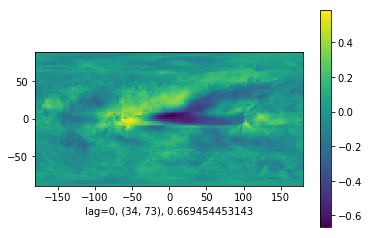

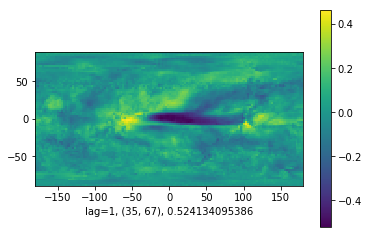

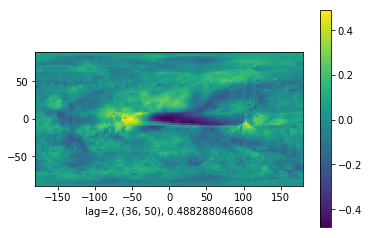

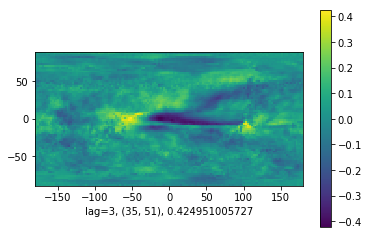

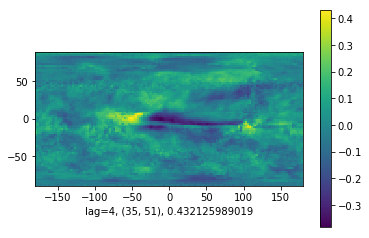

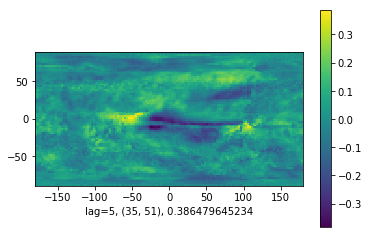

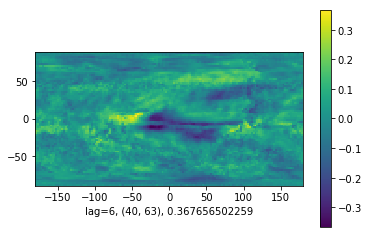

In [17]:
# reshape the data back to its orginial dimension
a = a.reshape(a.shape[0]*a.shape[1], a.shape[2], a.shape[3])

lag = 6
for t in range(lag+1):
    soi = df.values[336+t:,0]   # if t=0, soi starts from 1982    
    soi = soi.reshape(soi.shape[0], 1)

    precip = a[0:-4-t,:,:]
    
    r2 = []
    for i in range(precip.shape[1]):
        for j in range(precip.shape[2]):
            r2_index = pearsonr(soi, precip[:,i,j].reshape(precip.shape[0], 1))[0]
            r2.append(r2_index)

    r2_map = np.array(r2).reshape(precip.shape[1], precip.shape[2])
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)

    pyplot.figure()
    pyplot.imshow(r2_map, extent=[-180, +180, -90, 90])
    pyplot.colorbar()
    
    r2_map = np.abs(r2_map)
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)
    pyplot.xlabel('lag=' + str(t) + ', ' + str(max_index) + ', ' + str(r2_map[max_index]))
    print(max_index, r2_map[max_index])
    # np.savetxt("preprocessed/enso_precipanomaly_reshaped.csv", precip[:, max_index[0], max_index[1]], '%6.2f', delimiter=",")

nc.close()    

According to the results, point (34, 73) has the highest correlation when lag equals 0.